# Macro Directional (ETF)

Asset Classes: Commodities, REITs, Bonds, Equity Indices, and Bitcoin

## Import Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
from pandas.tseries.offsets import BDay
import pandas_datareader as wb

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import datetime as dt

## Retrieve Data

In [2]:
# define tickers
equities = 'QQQ XLY XLV XLP MCHI VWO VIG ARKK ESGU MTUM'.split()
bonds = 'BND BNDX EMB HYG VCSH LQD VCLT SHY IEF TLT TIP'.split()
reits = 'VNQ VNQI'.split()
commods = 'GLD SLV XLE'.split()
crypto = 'BITO'.split()
tickers = equities + bonds + reits + commods + crypto
len(tickers)

27

In [3]:
%%time
data = wb.DataReader(name=tickers, data_source='yahoo', start='2000-01-01', end=dt.date.today())['Adj Close']
data.loc[data.index[-1]+BDay(1),:] = np.nan

Wall time: 31.8 s


## Set Parameters and Dates

In [4]:
# strategy parameters
lookback = 12
hold = 3
seasonality = None
post_exdate = 1

threshold = 0.90
max_assets = 15
min_assets = 10

# resample dates to monthly timeframe
critical = data.resample('BMS').mean().index
while [date for date in critical if date not in data.index] != []:
    critical = [date if date in data.index else date+BDay(1) for date in critical]
critical = critical[seasonality:]
    
# capture lookback start dates
start = critical[:-lookback:hold]

# capture rebalance dates (after ex-date)
rebalance_on = critical[lookback::hold]
rebalance_on = [date+BDay(post_exdate) for date in rebalance_on]

# capture end of holding dates (on ex-date)
hold_until = [date+BDay(post_exdate)-BDay(1) for date in critical[lookback+hold::hold]]

# capture lookback end dates
end = [date-BDay(1) for date in rebalance_on]

# check sample of lookback and allocation period
i = 51
print(f"Lookback starts : {start[i].date()}")
print(f"Lookback ends   : {end[i].date()}")
print(f"Rebalance on    : {rebalance_on[i].date()}")
print(f"Hold until      : {hold_until[i].date()}")

Lookback starts : 2012-09-04
Lookback ends   : 2013-09-03
Rebalance on    : 2013-09-04
Hold until      : 2013-12-02


## Create Allocation DataFrame

In [5]:
# prepare allocation dataframe
allocation = data.copy()
allocation.loc[:] = np.nan

# loop over rebalancing period
for i in range(len(rebalance_on)):
    
    # define dates for ease of reference
    start_look = start[i]
    end_look = end[i]
    rebal_on = rebalance_on[i]
    try: hold_till = hold_until[i]
    except: hold_till = None
    
    # slice lookback window and drop incomplete dataset
    df = data.loc[start_look:end_look].dropna(axis=1, how='any')
    
    # capture maximum and last price during lookback period
    max_price = df.max()
    last_price = df.iloc[-1]
    ratio = last_price / max_price
    
    # select long candidates
    long_names = last_price[last_price > (threshold * max_price)].index.tolist()
    long_names = ratio[long_names].nlargest(max_assets).index.tolist()
    
    # define conditions for long trades
    if len(long_names) >= min_assets:
        
        print(f"Lookback starts : {start_look.date()}")
        print(f"Lookback ends   : {end_look.date()}")
        print(f"Hold from       : {rebal_on.date()}")
        if hold_till is not None:
            print(f"Hold until      : {hold_till.date()}")
        else: pass
        print(f"Long names ({len(long_names)}) : {', '.join(long_names)}")
        print('==========================================')
        
        # allocate capital equally
        allocation.loc[rebal_on:hold_till, long_names] = 1 / len(long_names)

Lookback starts : 2004-03-01
Lookback ends   : 2005-03-01
Hold from       : 2005-03-02
Hold until      : 2005-06-01
Long names (10) : XLP, SHY, TIP, LQD, IEF, XLE, XLV, XLY, TLT, QQQ
Lookback starts : 2004-06-01
Lookback ends   : 2005-06-01
Hold from       : 2005-06-02
Hold until      : 2005-09-01
Long names (10) : SHY, IEF, TLT, TIP, LQD, XLV, XLP, QQQ, XLE, XLY
Lookback starts : 2004-09-01
Lookback ends   : 2005-09-01
Hold from       : 2005-09-02
Hold until      : 2005-12-01
Long names (10) : SHY, XLE, TIP, IEF, LQD, TLT, XLV, XLP, QQQ, XLY
Lookback starts : 2004-12-01
Lookback ends   : 2005-12-01
Hold from       : 2005-12-02
Hold until      : 2006-03-01
Long names (12) : QQQ, GLD, SHY, XLP, VNQ, TIP, IEF, LQD, XLV, XLY, TLT, XLE
Lookback starts : 2005-03-01
Lookback ends   : 2006-03-01
Hold from       : 2006-03-02
Hold until      : 2006-06-01
Long names (12) : SHY, VNQ, TIP, XLP, XLV, GLD, LQD, IEF, XLY, TLT, QQQ, XLE
Lookback starts : 2005-06-01
Lookback ends   : 2006-06-01
Hold fr

Lookback starts : 2014-06-02
Lookback ends   : 2015-06-01
Hold from       : 2015-06-02
Hold until      : 2015-09-01
Long names (15) : XLV, HYG, SHY, MTUM, VCSH, QQQ, XLY, EMB, VIG, BND, BNDX, XLP, TIP, IEF, VNQI
Lookback starts : 2014-09-02
Lookback ends   : 2015-09-01
Hold from       : 2015-09-02
Hold until      : 2015-12-01
Long names (12) : SHY, VCSH, BND, IEF, BNDX, TIP, EMB, HYG, LQD, MTUM, XLP, XLY
Lookback starts : 2014-12-01
Lookback ends   : 2015-12-01
Hold from       : 2015-12-02
Hold until      : 2016-03-01
Long names (15) : QQQ, MTUM, XLY, VCSH, SHY, BNDX, BND, IEF, XLP, EMB, VIG, LQD, TIP, ARKK, HYG
Lookback starts : 2015-03-02
Lookback ends   : 2016-03-01
Hold from       : 2016-03-02
Hold until      : 2016-06-01
Long names (15) : BNDX, SHY, BND, VCSH, XLP, EMB, GLD, IEF, TIP, LQD, TLT, VIG, MTUM, VNQ, XLY
Lookback starts : 2015-06-01
Lookback ends   : 2016-06-01
Hold from       : 2016-06-02
Hold until      : 2016-09-01
Long names (15) : BNDX, MTUM, SHY, VCSH, BND, EMB, LQ

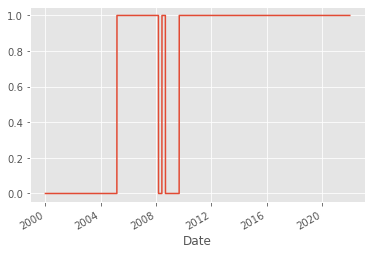

In [6]:
allocation.sum(axis=1).plot(); plt.show() # long-only

## Backtest Strategy

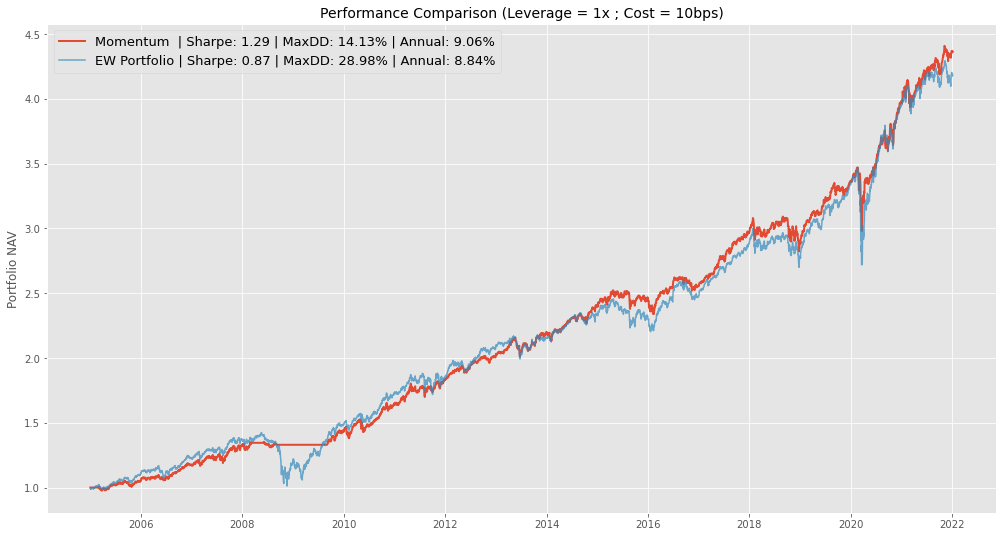

In [7]:
# set trading cost (in bps)
tc = 10
leverage = 1
start_test = '2005'
end_test = None

# calculate daily portfolio return
strat = (data.pct_change() * allocation.shift(2) * leverage).sum(axis=1).loc[start_test:end_test]
equal = data.loc[start_test:end_test].pct_change().mean(axis=1)

# deduct transaction cost
cost = tc / 10000
turnover = (allocation * leverage).diff().shift().fillna(0).abs()
strat = strat - (turnover * cost).sum(axis=1)

# functionalize Sharpe ratio
def sharpe(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(250)

# functionalize maximum drawdown
def max_dd(daily_return):
    roll_max = (daily_return + 1).cumprod().expanding().max()
    daily_dd = (daily_return + 1).cumprod() / roll_max.values - 1.0
    max_dd = daily_dd.abs().max() * 100
    return max_dd

# functionalize annualized return
def annualized_return(daily_return):
    cum_return = (daily_return + 1).cumprod().dropna()
    ann_return = (cum_return.iloc[-1] / cum_return.iloc[0]) ** (1 / len(cum_return) * 252) - 1
    ann_return = ann_return * 100
    return ann_return

# plot PnL
plt.figure(figsize=(17,9))
plt.plot((strat + 1).cumprod(), label=f"Momentum  | Sharpe: {sharpe(strat):.2f} | MaxDD: {max_dd(strat):.2f}% | Annual: {annualized_return(strat):.2f}%", lw=2)
plt.plot((equal + 1).cumprod(), label=f"EW Portfolio | Sharpe: {sharpe(equal):.2f} | MaxDD: {max_dd(equal):.2f}% | Annual: {annualized_return(equal):.2f}%", alpha=0.7)
plt.title(f'Performance Comparison (Leverage = {leverage}x ; Cost = {tc}bps)', fontsize=14)
plt.ylabel('Portfolio NAV', fontsize=12)
plt.legend(fontsize=13)
plt.show()

# save return to csv file
strat.to_csv('macro_momentum_return.csv')

## Annual Returns Distribution

In [8]:
strat.dropna().resample('A').sum() * 100

Date
2005-12-31    4.626
2006-12-31   11.959
2007-12-31   12.237
2008-12-31    0.562
2009-12-31    7.268
2010-12-31   14.763
2011-12-31   10.878
2012-12-31    9.445
2013-12-31    9.116
2014-12-31    8.625
2015-12-31    2.594
2016-12-31    4.149
2017-12-31   15.068
2018-12-31   -1.868
2019-12-31   14.730
2020-12-31   17.876
2021-12-31    9.357
2022-12-31    0.000
Freq: A-DEC, dtype: float64

## Allocation Distribution

In [9]:
try:
    dist = pd.concat([allocation.loc[rebalance_on[-5]],
                      allocation.loc[rebalance_on[-4]],
                      allocation.loc[rebalance_on[-3]],
                      allocation.loc[rebalance_on[-2]],
                      allocation.loc[rebalance_on[-1]]], axis=1).replace(np.nan, '')
except:
    dist = pd.concat([allocation.loc[rebalance_on[-5]],
                      allocation.loc[rebalance_on[-4]],
                      allocation.loc[rebalance_on[-3]],
                      allocation.loc[rebalance_on[-2]],
                      allocation.iloc[-1]], axis=1).replace(np.nan, '')

dist.sort_index()

,2020-12-02,2021-03-02,2021-06-02,2021-09-02,2021-12-02
Symbols,,,,,
ARKK,0.067,,,,
BITO,,,,,
BND,0.067,0.067,,0.067,0.067
BNDX,0.067,0.067,0.067,,0.067
EMB,0.067,0.067,0.067,0.067,0.067
ESGU,0.067,0.067,0.067,0.067,0.067
GLD,,,,,
HYG,0.067,0.067,0.067,0.067,0.067
IEF,,,,,0.067


# The End